# 1) Imports

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from google.colab import drive

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)


device: cuda


# 2) Load CSV

In [2]:

drive.mount('/content/drive')

CSV_PATH = "/content/drive/MyDrive/Alcohol_sales.csv"

df = pd.read_csv(CSV_PATH)

# first column as the sales series
target_col = df.select_dtypes(include=[np.number]).columns[0]
y = df[target_col].values.astype(np.float32)

print("target_col:", target_col)
print("len:", len(y))


Mounted at /content/drive
target_col: S4248SM144NCEN
len: 398


# 3) Train/Test split

In [3]:

test_ratio = 0.2
N = len(y)
train_size = int(N * (1 - test_ratio))

y_train = y[:train_size]
y_test  = y[train_size:]
print("train:", len(y_train), "test:", len(y_test))


train: 318 test: 80


# 4) Use differencing
# d[t] = y[t] - y[t-1]

In [4]:

d = np.diff(y)

d_train = d[:train_size-1]
d_test  = d[train_size-1:]  # includes the first diff that touches the test part
print("diff train:", len(d_train), "diff test:", len(d_test))

# Scale diffs using train only (z-score)
mean_d = d_train.mean()
std_d  = d_train.std() + 1e-8

d_train = ((d_train - mean_d) / std_d).astype(np.float32)
d_test  = ((d_test  - mean_d) / std_d).astype(np.float32)

seq_len = 36
d_test_full = np.concatenate([d_train[-seq_len:], d_test]).astype(np.float32)


diff train: 317 diff test: 80


# 5) Dataset (sliding window)

In [5]:

class DiffDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]          # (T,)
        y = self.data[idx+self.seq_len]              # scalar
        x = torch.tensor(x).unsqueeze(-1)            # (T,1)
        y = torch.tensor([y], dtype=torch.float32)   # (1,)
        return x, y

train_ds = DiffDataset(d_train, seq_len)
test_ds  = DiffDataset(d_test_full, seq_len)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

len(train_ds), len(test_ds)


(281, 80)

# 6) LSTM model

In [6]:
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=128, num_layers=2, batch_first=True)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1])

model = LSTMModel().to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

best_path = "best_lstm.pt"


# 7) Predict on test and plot

In [7]:
def inv_diff(z_diff):
    # inverse z-score for diffs
    return z_diff * std_d + mean_d

def predict_plot(epoch_label):
    model.eval()
    pred_z = []

    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            pred = model(x).cpu().numpy().reshape(-1)
            pred_z.append(pred)

    pred_z = np.concatenate(pred_z)
    pred_d = inv_diff(pred_z)


    y_prev = y[train_size - 1]
    pred_y = []
    true_y = []

    for k in range(len(pred_d)):
        y_true_next = y[train_size + k]
        y_pred_next = y_prev + pred_d[k]

        pred_y.append(y_pred_next)
        true_y.append(y_true_next)

        # forward(simple and stable)
        y_prev = y_true_next

    pred_y = np.array(pred_y, dtype=np.float32)
    true_y = np.array(true_y, dtype=np.float32)

    mse = float(np.mean((pred_y - true_y) ** 2))

    plt.figure(figsize=(11,4))
    plt.plot(true_y, label="True")
    plt.plot(pred_y, label="Predicted")
    plt.title(f"Epoch {epoch_label} | Test MSE = {mse:.2f}")
    plt.xlabel("Time Index (Test)")
    plt.ylabel(target_col)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return mse


# 8) Train (every 10 epochs: test prediction + plot + save best weights)

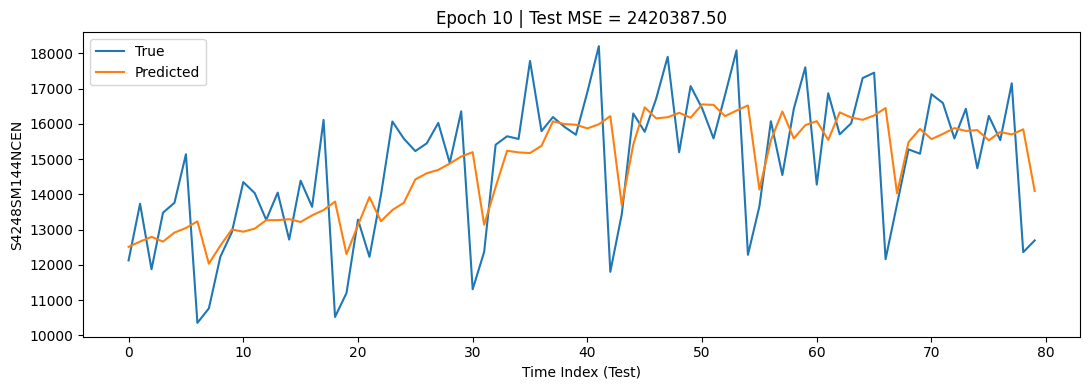

Epoch 10 | Test MSE: 2420387.50
Saved best weights -> best_lstm.pt


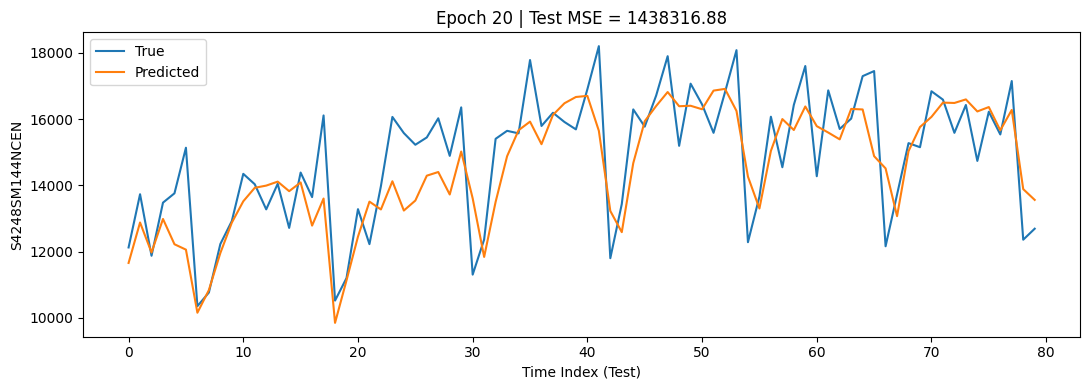

Epoch 20 | Test MSE: 1438316.88
Saved best weights -> best_lstm.pt


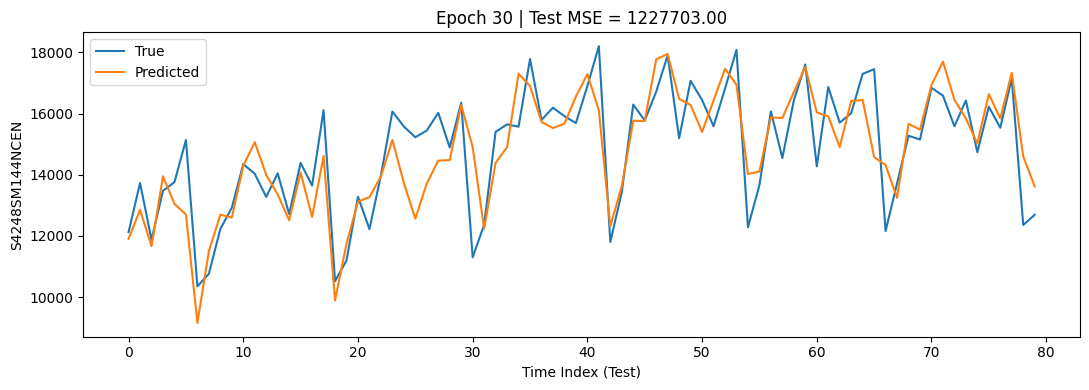

Epoch 30 | Test MSE: 1227703.00
Saved best weights -> best_lstm.pt


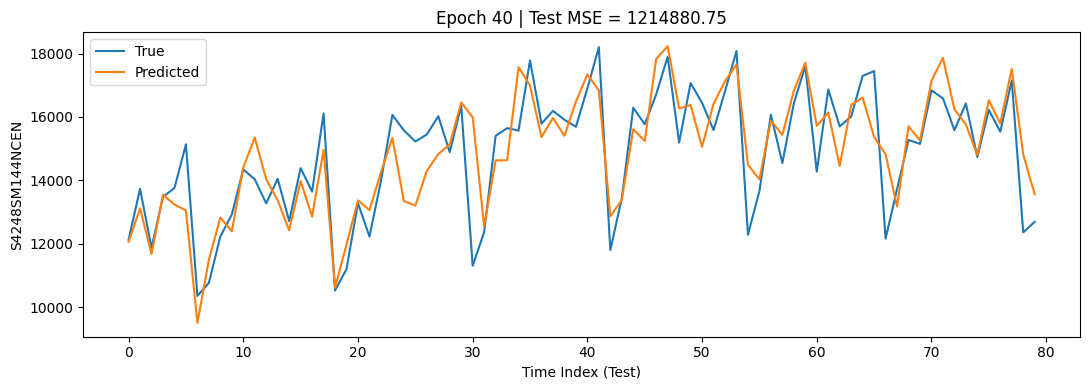

Epoch 40 | Test MSE: 1214880.75
Saved best weights -> best_lstm.pt


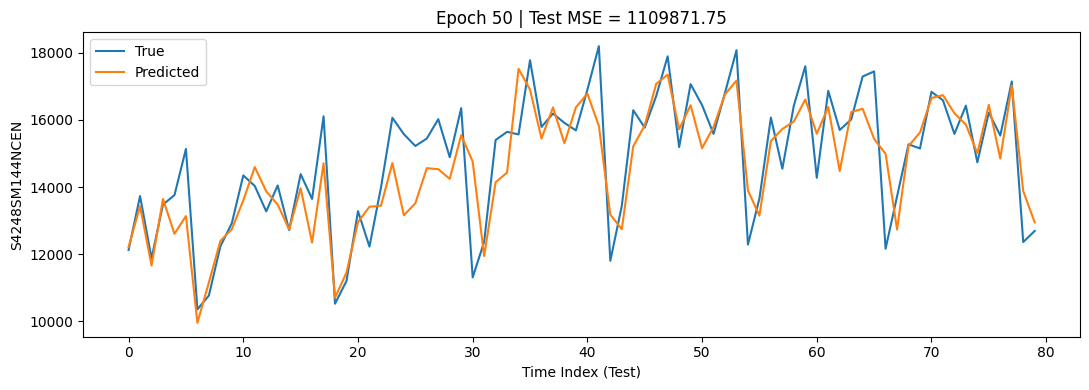

Epoch 50 | Test MSE: 1109871.75
Saved best weights -> best_lstm.pt


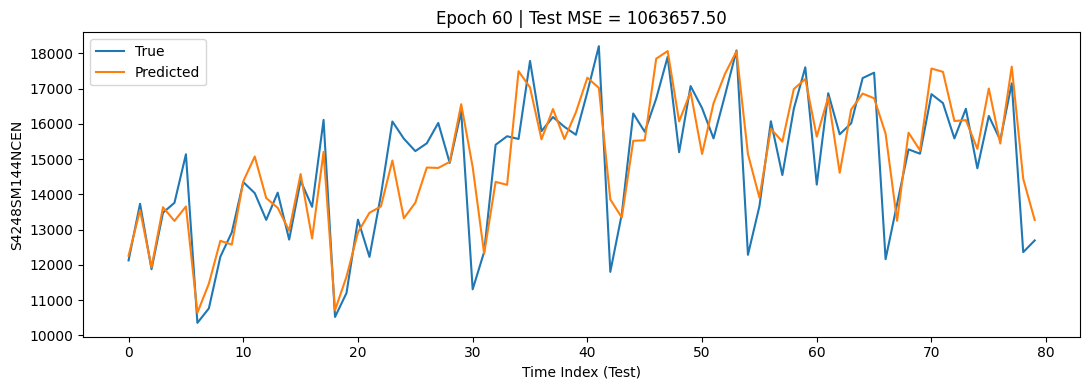

Epoch 60 | Test MSE: 1063657.50
Saved best weights -> best_lstm.pt


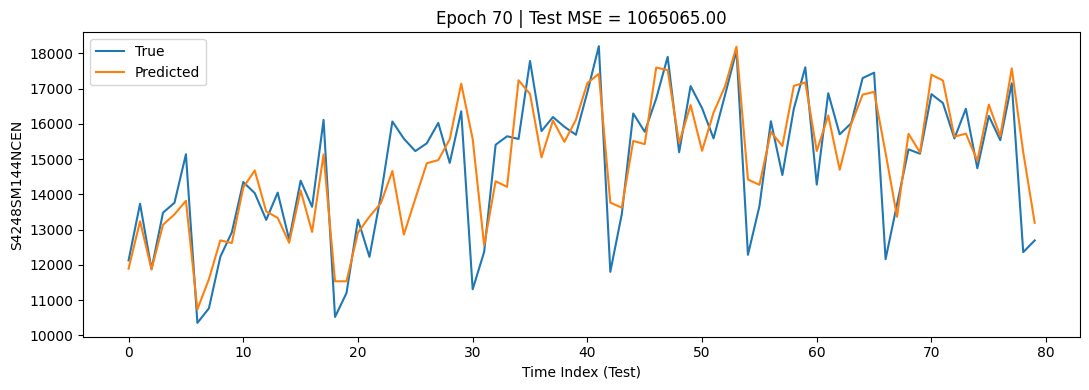

Epoch 70 | Test MSE: 1065065.00


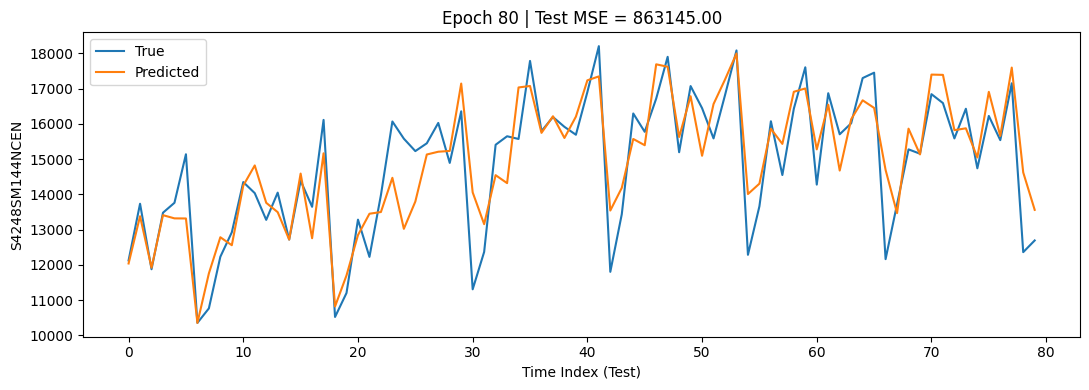

Epoch 80 | Test MSE: 863145.00
Saved best weights -> best_lstm.pt


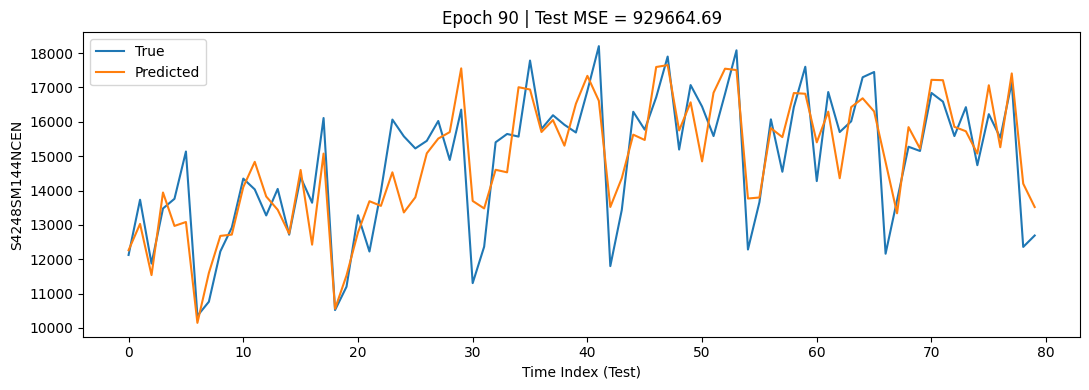

Epoch 90 | Test MSE: 929664.69


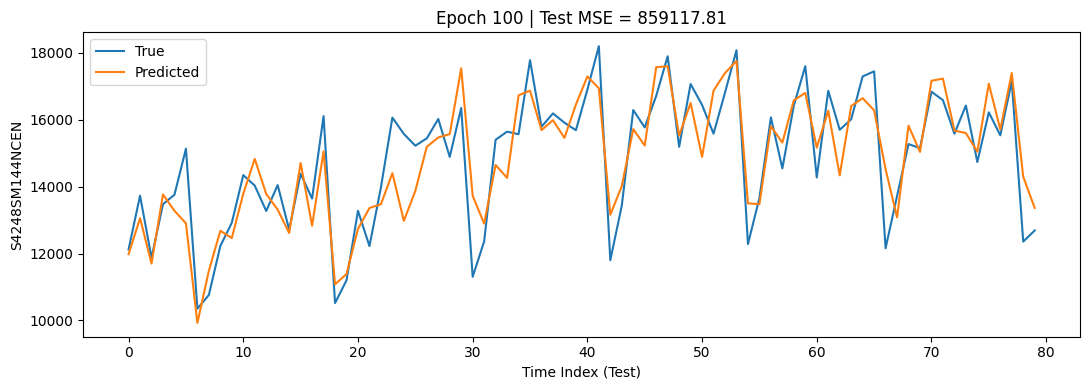

Epoch 100 | Test MSE: 859117.81
Saved best weights -> best_lstm.pt


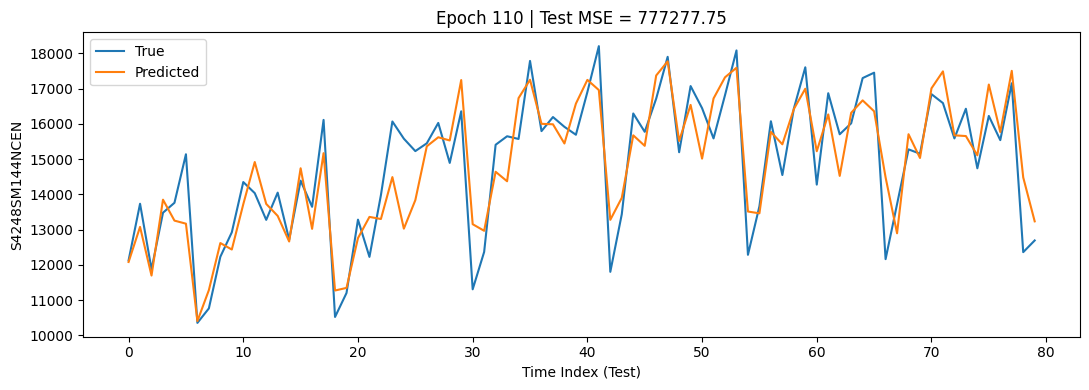

Epoch 110 | Test MSE: 777277.75
Saved best weights -> best_lstm.pt


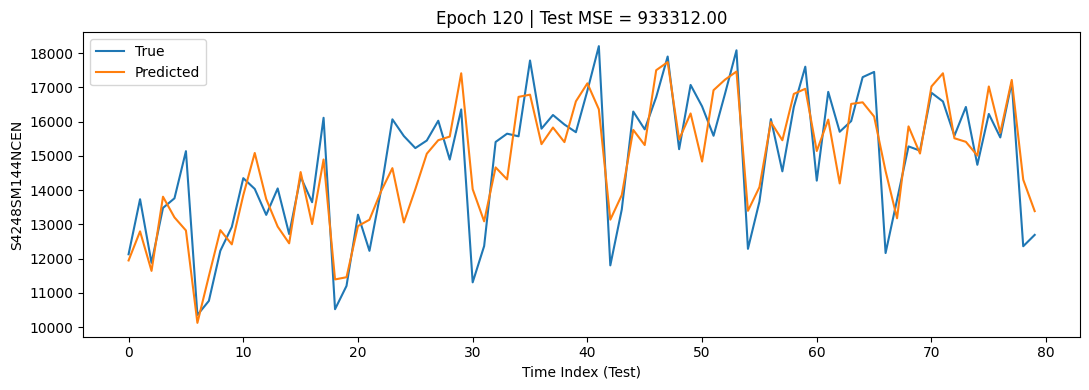

Epoch 120 | Test MSE: 933312.00


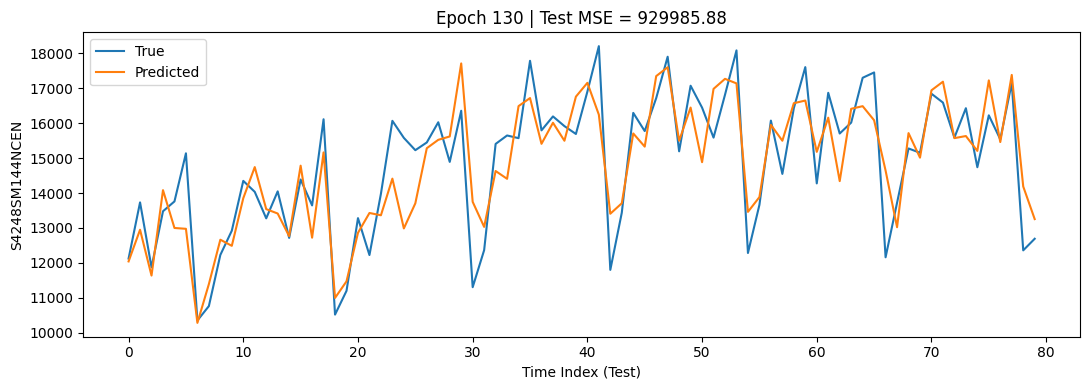

Epoch 130 | Test MSE: 929985.88


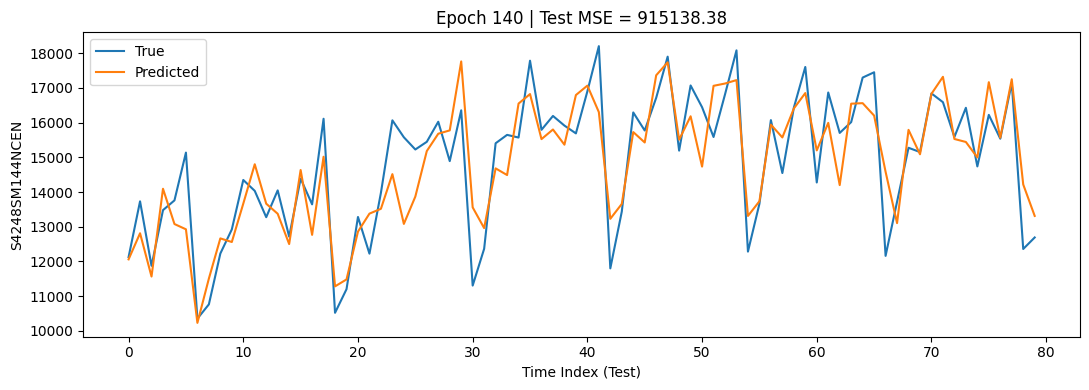

Epoch 140 | Test MSE: 915138.38


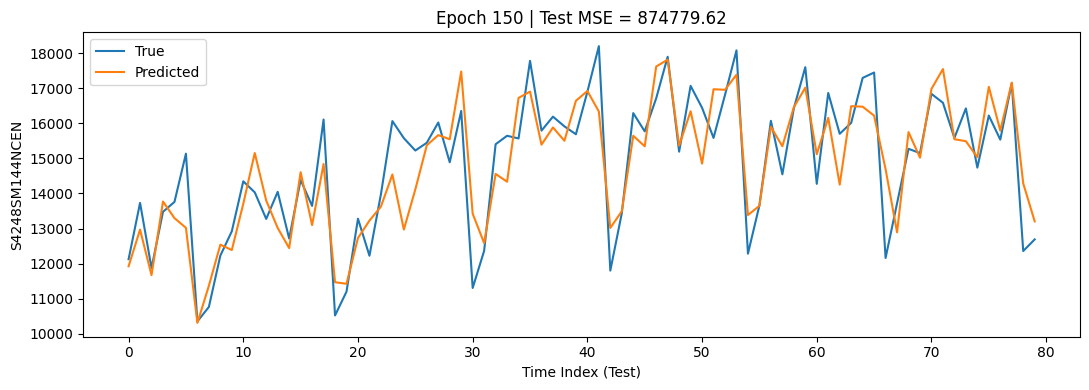

Epoch 150 | Test MSE: 874779.62


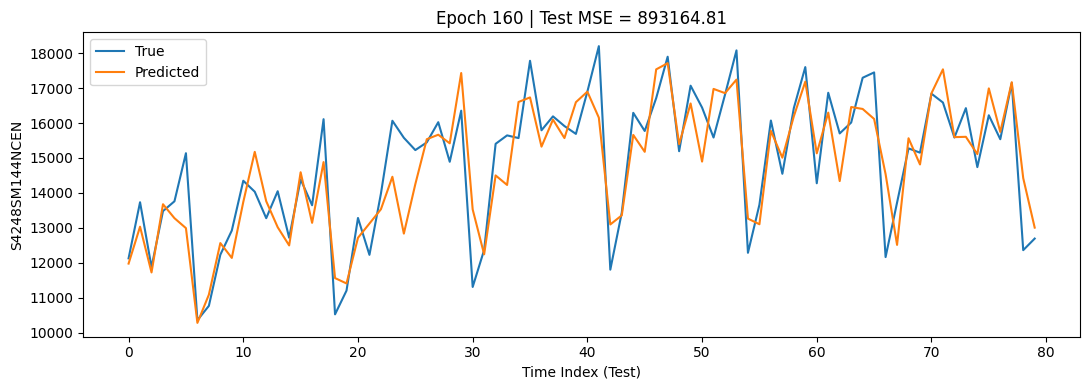

Epoch 160 | Test MSE: 893164.81


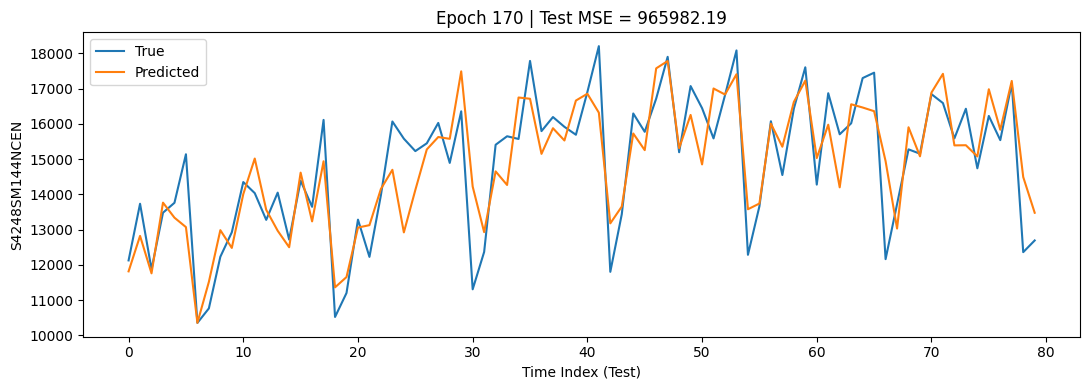

Epoch 170 | Test MSE: 965982.19


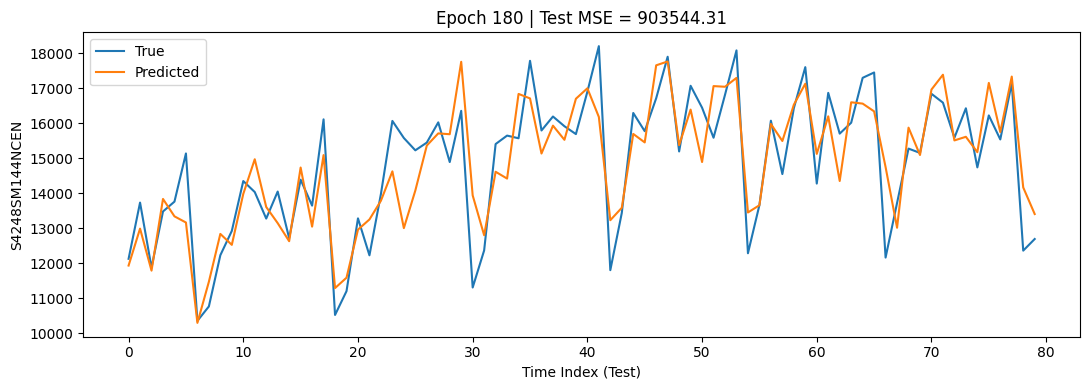

Epoch 180 | Test MSE: 903544.31


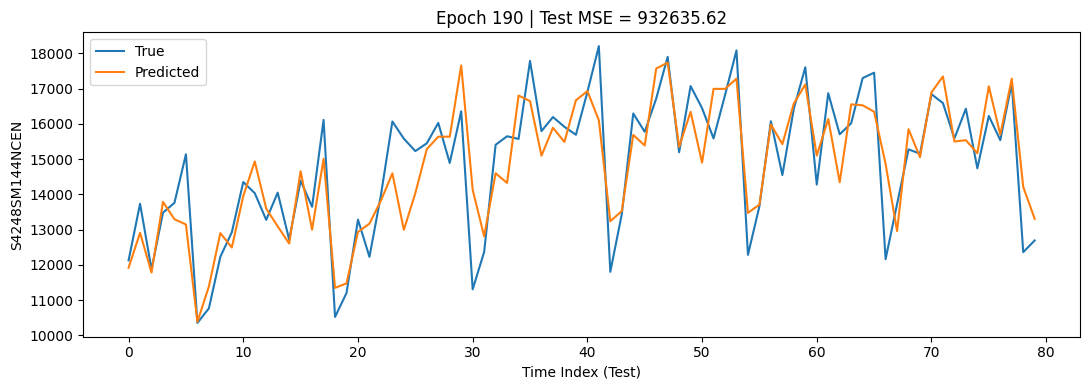

Epoch 190 | Test MSE: 932635.62


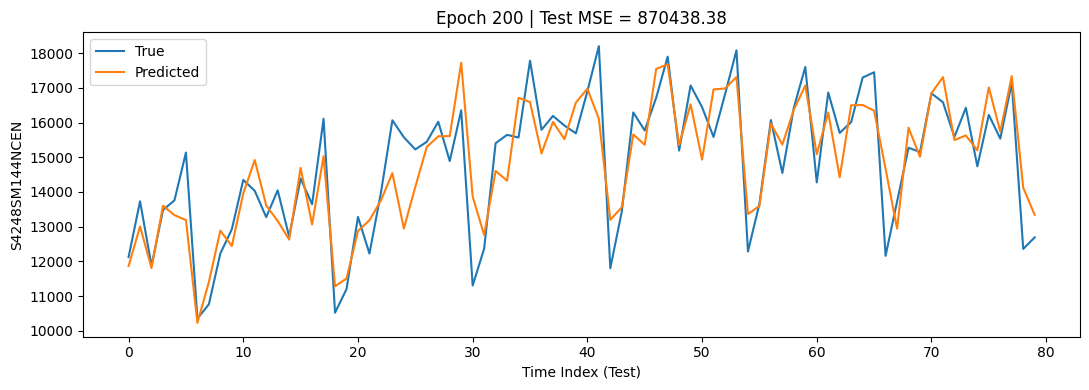

Epoch 200 | Test MSE: 870438.38
Done. Best Test MSE: 777277.75


In [8]:

epochs = 200
best_mse = float("inf")

for epoch in range(1, epochs + 1):
    model.train()
    for x, yb in train_loader:
        x, yb = x.to(device), yb.to(device)
        opt.zero_grad()
        yhat = model(x)
        loss = loss_fn(yhat, yb)
        loss.backward()
        opt.step()

    # Required by the assignment
    if epoch % 10 == 0:
        test_mse = predict_plot(epoch)
        print(f"Epoch {epoch} | Test MSE: {test_mse:.2f}")

        # Save best model weights
        if test_mse < best_mse:
            best_mse = test_mse
            torch.save(model.state_dict(), best_path)
            print("Saved best weights ->", best_path)

print("Done. Best Test MSE:", best_mse)


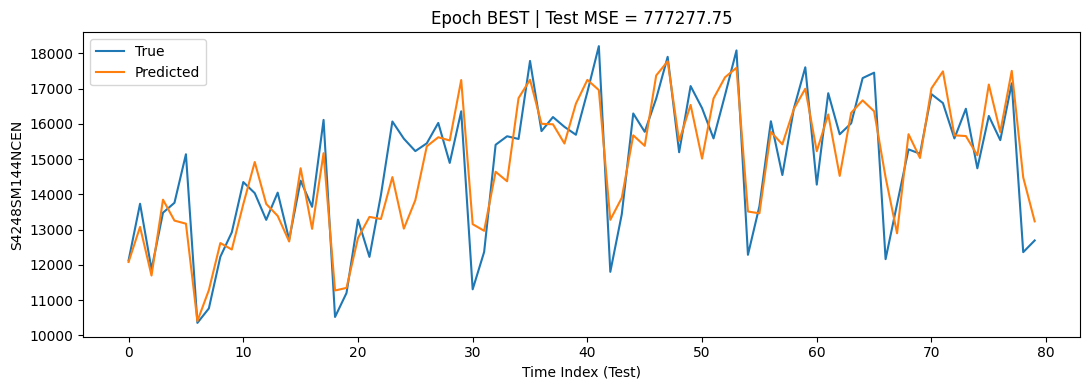

In [9]:
# 9) Load best weights and plot once more
model.load_state_dict(torch.load(best_path, map_location=device))
_ = predict_plot("BEST")
